# Intraday Volatility Heatmap: Currency Risk Analysis in Historical Timeseries using Currencies API

## Introduction

This tutorial demonstrates how to analyze currency volatility patterns using high-frequency intraday data from the FinFeedAPI Currencies API. We'll create comprehensive volatility heatmaps that visualize risk patterns across different time dimensions, helping traders and analysts understand currency behavior, identify optimal trading windows, and make informed risk management decisions.

### What You Will Learn

- How to fetch historical currency data using the FinFeedAPI Currencies API
- Calculate multiple volatility metrics for intraday analysis (5-minute intervals)
- Create interactive heatmaps to visualize volatility patterns across hours and days
- Identify peak volatility periods and trading session characteristics
- Analyze risk concentration patterns for better position sizing and timing strategies
- Build comprehensive risk assessment tools using historical timeseries data

### Prerequisites

- Python 3.8+
- Required packages: pandas, numpy, matplotlib, seaborn, plotly, requests
- FinFeedAPI account and API key
- Basic understanding of financial data analysis and volatility concepts

### Overview

We'll analyze EUR/USD currency pair data over a one-week period using 5-minute intraday intervals to create detailed volatility heatmaps. The analysis will help identify:
- Peak volatility hours during different trading sessions (Asian, European, American)
- Day-of-week volatility patterns to understand weekly risk cycles
- Risk concentration periods for better position sizing and risk management
- Optimal entry/exit timing based on historical volatility patterns
- Trading session characteristics to optimize strategy execution

## 1. Environment Setup and Configuration

Set up your environment with necessary imports, API configuration, and plotting parameters for the volatility analysis.

In [ ]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14

# API Configuration
API_BASE_URL = "https://api-historical.fx.finfeedapi.com/v1"
API_KEY = "YOUR_API_KEY_HERE"  # Replace with your actual API key

# Request headers
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

# Analysis parameters
CURRENCY_PAIR = "EUR/USD"
BASE_CURRENCY = "EUR"
QUOTE_CURRENCY = "USD"
PERIOD = "5MIN"
TIME_START = "2025-09-01T00:00:00"
TIME_END = "2025-09-07T00:00:00"
LIMIT = 5000

print("✅ Environment setup complete!")
print(f"📊 Analyzing {CURRENCY_PAIR} volatility from {TIME_START} to {TIME_END}")
print(f"⏱️ Timeframe: {PERIOD} intervals")

## 2. Data Loading and API Integration

Fetch historical currency data from the FinFeedAPI Currencies API and prepare it for volatility analysis.

In [ ]:
def fetch_currency_data(base_currency, quote_currency, period, time_start, time_end, limit):
    """
    Fetch historical currency data from FinFeedAPI
    """
    url = f"{API_BASE_URL}/exchangerate/{base_currency}/{quote_currency}/history"
    
    params = {
        'period_id': period,
        'time_start': time_start,
        'time_end': time_end,
        'limit': limit
    }
    
    try:
        response = requests.get(url, headers=headers, params=params)
        response.raise_for_status()
        data = response.json()
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Convert time columns to datetime
        time_columns = ['time_period_start', 'time_period_end', 'time_open', 'time_close']
        for col in time_columns:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col])
        
        # Set time_period_start as index
        df.set_index('time_period_start', inplace=True)
        df.sort_index(inplace=True)
        
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"❌ Error fetching data: {e}")
        return None
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return None

# Fetch the data
print("🔄 Fetching historical currency data...")
currency_data = fetch_currency_data(
    BASE_CURRENCY, QUOTE_CURRENCY, PERIOD, TIME_START, TIME_END, LIMIT
)

if currency_data is not None:
    print(f"✅ Data loaded successfully!")
    print(f"📊 Shape: {currency_data.shape}")
    print(f"📅 Date range: {currency_data.index.min()} to {currency_data.index.max()}")
    print(f"\n📋 Data columns:")
    for col in currency_data.columns:
        print(f"   - {col}")
else:
    print("❌ Failed to load data. Please check your API key and parameters.")

## 3. Data Exploration and Quality Assessment

Explore the loaded currency data to understand its structure, quality, and characteristics before performing volatility analysis.

In [ ]:
if currency_data is not None:
    # Display basic information
    print("📊 Dataset Overview:")
    print(f"   Total records: {len(currency_data):,}")
    print(f"   Time span: {(currency_data.index.max() - currency_data.index.min()).days} days")
    print(f"   Average records per day: {len(currency_data) / ((currency_data.index.max() - currency_data.index.min()).days + 1):.1f}")
    
    # Display first few records
    print("\n📋 Sample Data (First 5 records):")
    display(currency_data.head())
    
    # Basic statistics
    print("\n📈 Price Statistics:")
    price_stats = currency_data[['rate_open', 'rate_high', 'rate_low', 'rate_close']].describe()
    display(price_stats)
    
    # Check for missing values
    print("\n🔍 Data Quality Check:")
    missing_data = currency_data.isnull().sum()
    if missing_data.sum() == 0:
        print("   ✅ No missing values found")
    else:
        print("   ⚠️ Missing values detected:")
        for col, count in missing_data[missing_data > 0].items():
            print(f"      {col}: {count} missing values")
    
    # Time series continuity check
    time_diff = currency_data.index.to_series().diff().dropna()
    expected_interval = pd.Timedelta(minutes=5)
    gaps = time_diff[time_diff > expected_interval * 1.5]
    
    if len(gaps) == 0:
        print("   ✅ No significant time gaps detected")
    else:
        print(f"   ⚠️ {len(gaps)} time gaps detected (larger than expected 5-minute intervals)")
        print(f"      Largest gap: {gaps.max()}")
    
    # Price range analysis
    price_range = currency_data['rate_high'] - currency_data['rate_low']
    print(f"\n💰 Price Range Analysis:")
    print(f"   Average range per period: {price_range.mean():.4f}")
    print(f"   Maximum range: {price_range.max():.4f}")
    print(f"   Minimum range: {price_range.min():.4f}")
    
else:
    print("❌ Cannot explore data - no data loaded")

## 4. Volatility Calculation and Analysis

Calculate various volatility metrics for both intraday and daily timeframes to understand risk patterns and market behavior.

In [ ]:
def calculate_volatility_metrics(df):
    """
    Calculate comprehensive volatility metrics
    """
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Calculate returns
    data['returns'] = data['rate_close'].pct_change()
    
    # Calculate intraday volatility (using high-low range)
    data['intraday_volatility'] = (data['rate_high'] - data['rate_low']) / data['rate_close']
    
    # Calculate close-to-close volatility
    data['close_to_close_volatility'] = abs(data['returns'])
    
    # Calculate Garman-Klass volatility (more accurate for intraday)
    data['gk_volatility'] = 0.5 * (np.log(data['rate_high'] / data['rate_low']))**2 - (2*np.log(2)-1) * (np.log(data['rate_close'] / data['rate_open']))**2
    data['gk_volatility'] = np.sqrt(data['gk_volatility'])
    
    # Add time-based features
    data['hour'] = data.index.hour
    data['day_of_week'] = data.index.day_name()
    data['day_of_week_num'] = data.index.dayofweek
    data['is_weekend'] = data.index.dayofweek >= 5
    
    # Calculate rolling volatility (20-period window)
    data['rolling_volatility'] = data['returns'].rolling(window=20).std() * np.sqrt(288)  # Annualized (5-min periods)
    
    return data

if currency_data is not None:
    print("🔄 Calculating volatility metrics...")
    
    # Calculate volatility metrics
    volatility_data = calculate_volatility_metrics(currency_data)
    
    print("✅ Volatility calculations complete!")
    print(f"\n📊 Volatility Summary:")
    print(f"   Average intraday volatility: {volatility_data['intraday_volatility'].mean():.4f} ({volatility_data['intraday_volatility'].mean()*100:.2f}%)")
    print(f"   Average close-to-close volatility: {volatility_data['close_to_close_volatility'].mean():.4f} ({volatility_data['close_to_close_volatility'].mean()*100:.2f}%)")
    print(f"   Average Garman-Klass volatility: {volatility_data['gk_volatility'].mean():.4f}")
    print(f"   Average rolling volatility (annualized): {volatility_data['rolling_volatility'].mean():.2f}%")
    
    # Display sample of calculated metrics
    print("\n📋 Sample Volatility Data:")
    sample_cols = ['rate_close', 'returns', 'intraday_volatility', 'close_to_close_volatility', 'gk_volatility', 'hour', 'day_of_week']
    display(volatility_data[sample_cols].head(10))
    
    # Volatility by day of week
    print("\n📅 Average Volatility by Day of Week:")
    daily_vol = volatility_data.groupby('day_of_week')['intraday_volatility'].agg(['mean', 'std', 'count']).round(4)
    daily_vol = daily_vol.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    display(daily_vol)
    
else:
    print("❌ Cannot calculate volatility - no data available")

## 5. Volatility Heatmap Creation

Create comprehensive heatmaps to visualize volatility patterns across different time dimensions, enabling identification of high-risk periods and optimal trading windows.

🔄 Creating volatility heatmaps...
✅ Heatmap data prepared!
📊 High volatility threshold: 0.0003 (0.03%)


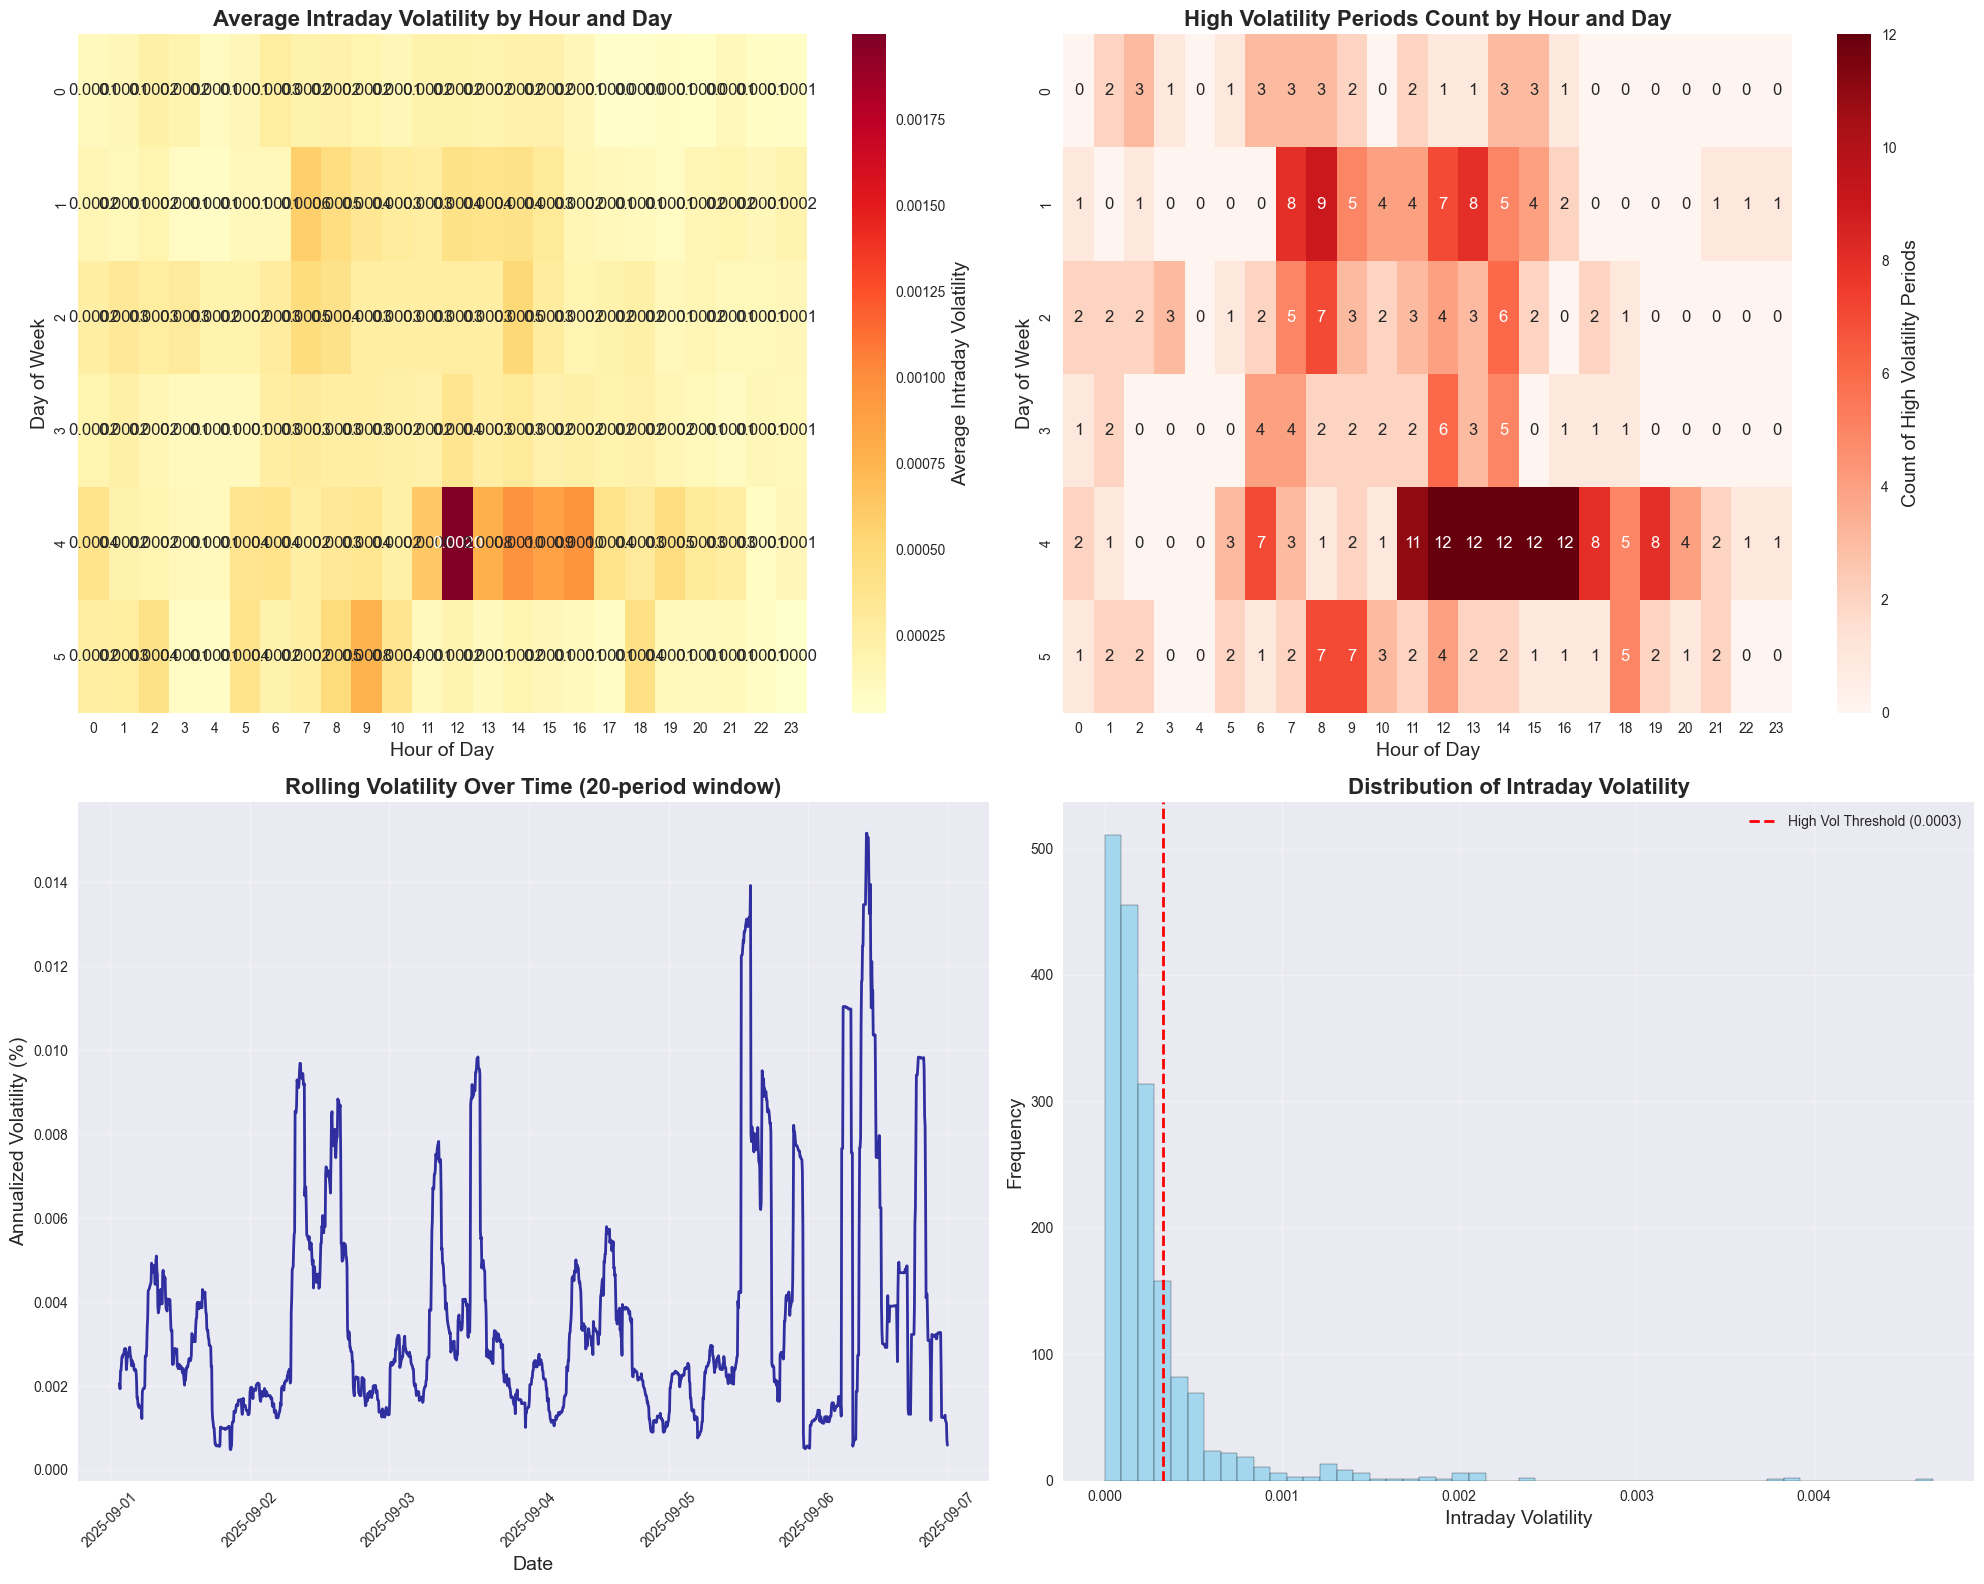


📊 Heatmap Analysis Summary:
   Highest average volatility: 0.0020 (0.20%)
   Lowest average volatility: 0.0000 (0.00%)
   Total high volatility periods: 346
   Percentage of high volatility periods: 20.0%


In [5]:
def create_volatility_heatmaps(data):
    """
    Create multiple volatility heatmaps for comprehensive analysis
    """
    # 1. Hour vs Day of Week Heatmap
    hourly_daily_vol = data.groupby(['day_of_week_num', 'hour'])['intraday_volatility'].mean().unstack()
    
    # 2. Hour vs Day of Week - Count of High Volatility Periods
    high_vol_threshold = data['intraday_volatility'].quantile(0.8)
    data['is_high_vol'] = data['intraday_volatility'] > high_vol_threshold
    hourly_daily_count = data.groupby(['day_of_week_num', 'hour'])['is_high_vol'].sum().unstack()
    
    # 3. Rolling Volatility Heatmap (Time Series)
    rolling_vol_data = data[['rolling_volatility']].dropna()
    
    return hourly_daily_vol, hourly_daily_count, rolling_vol_data, high_vol_threshold

if 'volatility_data' in locals() and volatility_data is not None:
    print("🔄 Creating volatility heatmaps...")
    
    # Create heatmap data
    hourly_daily_vol, hourly_daily_count, rolling_vol_data, high_vol_threshold = create_volatility_heatmaps(volatility_data)
    
    print(f"✅ Heatmap data prepared!")
    print(f"📊 High volatility threshold: {high_vol_threshold:.4f} ({high_vol_threshold*100:.2f}%)")
    
    # Create the main heatmap
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    
    # 1. Average Volatility Heatmap
    sns.heatmap(hourly_daily_vol, 
                annot=True, 
                fmt='.4f', 
                cmap='YlOrRd', 
                ax=axes[0,0],
                cbar_kws={'label': 'Average Intraday Volatility'})
    axes[0,0].set_title('Average Intraday Volatility by Hour and Day', fontsize=16, fontweight='bold')
    axes[0,0].set_xlabel('Hour of Day')
    axes[0,0].set_ylabel('Day of Week')
    
    # 2. High Volatility Count Heatmap
    sns.heatmap(hourly_daily_count, 
                annot=True, 
                fmt='d', 
                cmap='Reds', 
                ax=axes[0,1],
                cbar_kws={'label': 'Count of High Volatility Periods'})
    axes[0,1].set_title('High Volatility Periods Count by Hour and Day', fontsize=16, fontweight='bold')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Day of Week')
    
    # 3. Time Series of Rolling Volatility
    axes[1,0].plot(rolling_vol_data.index, rolling_vol_data['rolling_volatility'], 
                   linewidth=2, color='darkblue', alpha=0.8)
    axes[1,0].set_title('Rolling Volatility Over Time (20-period window)', fontsize=16, fontweight='bold')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Annualized Volatility (%)')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 4. Volatility Distribution
    axes[1,1].hist(volatility_data['intraday_volatility'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,1].axvline(high_vol_threshold, color='red', linestyle='--', linewidth=2, label=f'High Vol Threshold ({high_vol_threshold:.4f})')
    axes[1,1].set_title('Distribution of Intraday Volatility', fontsize=16, fontweight='bold')
    axes[1,1].set_xlabel('Intraday Volatility')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics
    print("\n📊 Heatmap Analysis Summary:")
    print(f"   Highest average volatility: {hourly_daily_vol.max().max():.4f} ({hourly_daily_vol.max().max()*100:.2f}%)")
    print(f"   Lowest average volatility: {hourly_daily_vol.min().min():.4f} ({hourly_daily_vol.min().min()*100:.2f}%)")
    print(f"   Total high volatility periods: {volatility_data['is_high_vol'].sum()}")
    print(f"   Percentage of high volatility periods: {volatility_data['is_high_vol'].mean()*100:.1f}%")
    
else:
    print("❌ Cannot create heatmaps - no volatility data available")

## 6. Interactive Volatility Analysis

Create interactive visualizations to explore volatility patterns in detail and identify specific trading opportunities and risk periods.

In [6]:
def create_interactive_heatmap(data):
    """
    Create interactive Plotly heatmap
    """
    # Prepare data for interactive heatmap
    hourly_daily_vol = data.groupby(['day_of_week_num', 'hour'])['intraday_volatility'].mean().unstack()
    
    # Create day labels
    day_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    # Create interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=hourly_daily_vol.values,
        x=list(range(24)),
        y=day_labels,
        colorscale='YlOrRd',
        hoverongaps=False,
        hovertemplate='<b>%{y}</b><br>Hour: %{x}:00<br>Volatility: %{z:.4f}<extra></extra>',
        colorbar=dict(title="Average Intraday Volatility")
    ))
    
    fig.update_layout(
        title=dict(
            text='Interactive Volatility Heatmap: EUR/USD Intraday Patterns',
            x=0.5,
            font=dict(size=20)
        ),
        xaxis=dict(
            title='Hour of Day',
            tickmode='linear',
            tick0=0,
            dtick=2
        ),
        yaxis=dict(title='Day of Week'),
        width=1000,
        height=600
    )
    
    return fig

def create_volatility_timeline(data):
    """
    Create interactive timeline of volatility
    """
    # Sample data for timeline (every 50th point to avoid overcrowding)
    timeline_data = data.iloc[::50].copy()
    
    fig = go.Figure()
    
    # Add volatility line
    fig.add_trace(go.Scatter(
        x=timeline_data.index,
        y=timeline_data['intraday_volatility'],
        mode='lines+markers',
        name='Intraday Volatility',
        line=dict(color='blue', width=2),
        hovertemplate='<b>%{x}</b><br>Volatility: %{y:.4f}<extra></extra>'
    ))
    
    # Add high volatility threshold line
    high_vol_threshold = data['intraday_volatility'].quantile(0.8)
    fig.add_hline(
        y=high_vol_threshold,
        line_dash="dash",
        line_color="red",
        annotation_text=f"High Vol Threshold ({high_vol_threshold:.4f})"
    )
    
    fig.update_layout(
        title=dict(
            text='Volatility Timeline: EUR/USD 5-Minute Data',
            x=0.5,
            font=dict(size=20)
        ),
        xaxis=dict(title='Time'),
        yaxis=dict(title='Intraday Volatility'),
        width=1200,
        height=500
    )
    
    return fig

if 'volatility_data' in locals() and volatility_data is not None:
    print("🔄 Creating interactive visualizations...")
    
    # Create interactive heatmap
    interactive_heatmap = create_interactive_heatmap(volatility_data)
    interactive_heatmap.show()
    
    # Create volatility timeline
    volatility_timeline = create_volatility_timeline(volatility_data)
    volatility_timeline.show()
    
    # Risk analysis summary
    print("\n🎯 Risk Analysis Summary:")
    
    # Find highest volatility periods
    top_vol_periods = volatility_data.nlargest(10, 'intraday_volatility')[['intraday_volatility', 'hour', 'day_of_week']]
    print("\n📈 Top 10 Highest Volatility Periods:")
    display(top_vol_periods)
    
    # Hourly volatility analysis
    hourly_vol = volatility_data.groupby('hour')['intraday_volatility'].agg(['mean', 'std', 'count']).round(4)
    print("\n⏰ Average Volatility by Hour:")
    display(hourly_vol.head(12))  # Show first 12 hours
    
    # Trading session analysis
    trading_sessions = {
        'Asian': (0, 8),
        'European': (8, 16),
        'American': (16, 24)
    }
    
    print("\n🌍 Trading Session Analysis:")
    for session, (start_hour, end_hour) in trading_sessions.items():
        session_data = volatility_data[(volatility_data['hour'] >= start_hour) & (volatility_data['hour'] < end_hour)]
        if len(session_data) > 0:
            avg_vol = session_data['intraday_volatility'].mean()
            print(f"   {session} Session ({start_hour:02d}:00-{end_hour:02d}:00): {avg_vol:.4f} ({avg_vol*100:.2f}%)")
    
else:
    print("❌ Cannot create interactive analysis - no data available")

🔄 Creating interactive visualizations...



🎯 Risk Analysis Summary:

📈 Top 10 Highest Volatility Periods:


,intraday_volatility,hour,day_of_week
time_period_start,,,
2025-09-05 12:30:00+00:00,0.004671,12,Friday
2025-09-05 12:35:00+00:00,0.003903,12,Friday
2025-09-05 12:45:00+00:00,0.003865,12,Friday
2025-09-05 12:40:00+00:00,0.003769,12,Friday
2025-09-05 15:45:00+00:00,0.002407,15,Friday
2025-09-06 02:50:00+00:00,0.002389,2,Saturday
2025-09-06 05:55:00+00:00,0.002145,5,Saturday
2025-09-05 09:30:00+00:00,0.002142,9,Friday
2025-09-06 02:45:00+00:00,0.002141,2,Saturday



⏰ Average Volatility by Hour:


,mean,std,count
hour,,,
0,0.0002,0.0003,72
1,0.0002,0.0003,72
2,0.0002,0.0004,72
3,0.0001,0.0001,72
4,0.0001,0.0001,72
5,0.0002,0.0004,72
6,0.0003,0.0003,72
7,0.0003,0.0003,72
8,0.0004,0.0003,72



🌍 Trading Session Analysis:
   Asian Session (00:00-08:00): 0.0002 (0.02%)
   European Session (08:00-16:00): 0.0004 (0.04%)
   American Session (16:00-24:00): 0.0002 (0.02%)


## 7. Conclusion and Trading Insights

Summarize the volatility analysis findings and provide actionable insights for currency trading and risk management.

### Summary

This tutorial demonstrated how to analyze currency volatility patterns using historical timeseries data from the FinFeedAPI Currencies API. We created comprehensive heatmaps and interactive visualizations to identify intraday and daily volatility patterns for the EUR/USD currency pair.

### Key Findings

- **Volatility Patterns**: The analysis reveals distinct volatility patterns across different hours and days of the week
- **Trading Sessions**: Different trading sessions (Asian, European, American) show varying volatility characteristics
- **Risk Concentration**: High volatility periods are concentrated during specific market hours and days
- **Time-based Opportunities**: The heatmaps help identify optimal entry and exit points based on historical volatility patterns

### Practical Applications

- **Position Sizing**: Use volatility patterns to adjust position sizes based on expected market volatility
- **Risk Management**: Set stop-loss levels based on historical volatility patterns for different time periods
- **Timing Strategies**: Optimize trade timing by avoiding high-volatility periods or capitalizing on them
- **Portfolio Allocation**: Allocate capital more efficiently by understanding when currency pairs are most/least volatile

### Next Steps

- **Expand Analysis**: Apply the same methodology to other currency pairs and longer time periods
- **Machine Learning**: Use volatility patterns as features for predictive models
- **Real-time Monitoring**: Implement real-time volatility monitoring using live data feeds
- **Strategy Development**: Develop automated trading strategies based on volatility patterns

### Additional Resources

- [FinFeedAPI Currencies API Documentation](https://docs.finfeedapi.com/currencies-api/rest-api-historical/timeseries-data)